<a href="https://colab.research.google.com/github/Lohitasrith01/Multi-Agent-Autonomous-Drone-Navigation-Using-Reinforcement-Learning-in-AirSim-/blob/main/multi_agent_qlearning_gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

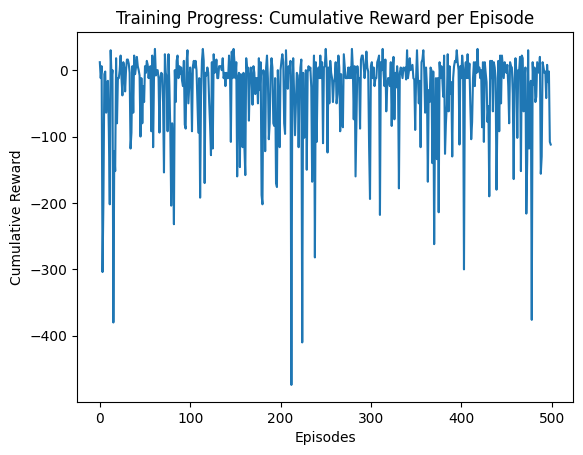

In [ ]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

class SimpleGridEnv:
    def __init__(self, num_agents=2, grid_size=5, obstacle_count=3):
        self.grid_size = grid_size
        self.num_agents = num_agents
        self.obstacle_count = obstacle_count
        self.actions = [0, 1, 2, 3]  # Up, Down, Left, Right
        self.reset()

    def reset(self):
        self.agent_positions = np.array([[0, 0] for _ in range(self.num_agents)])
        self.goal_positions = [(self.grid_size - 1, self.grid_size - 1)] * self.num_agents
        self.obstacle_positions = [self.random_position() for _ in range(self.obstacle_count)]
        self.steps_taken = 0
        return self.get_state()

    def random_position(self):
        return (np.random.randint(self.grid_size), np.random.randint(self.grid_size))

    def get_state(self):
        return tuple(map(tuple, self.agent_positions)) + tuple(self.obstacle_positions)

    def distance_to_goal(self, agent_pos, goal_pos):
        return abs(agent_pos[0] - goal_pos[0]) + abs(agent_pos[1] - goal_pos[1])

    def step(self, actions):
        rewards = np.zeros(self.num_agents)
        done = False
        self.steps_taken += 1

        for i, action in enumerate(actions):
            prev_distance = self.distance_to_goal(self.agent_positions[i], self.goal_positions[i])

            # Move the agent based on the action
            if action == 0 and self.agent_positions[i][1] < self.grid_size - 1:  # Up
                self.agent_positions[i][1] += 1
            elif action == 1 and self.agent_positions[i][1] > 0:  # Down
                self.agent_positions[i][1] -= 1
            elif action == 2 and self.agent_positions[i][0] > 0:  # Left
                self.agent_positions[i][0] -= 1
            elif action == 3 and self.agent_positions[i][0] < self.grid_size - 1:  # Right
                self.agent_positions[i][0] += 1

            # Check if agent reached goal
            if tuple(self.agent_positions[i]) == self.goal_positions[i]:
                rewards[i] += 50  # Significantly large reward for reaching the goal
                done = True
            else:
                # Distance-based Reward/Penalty
                new_distance = self.distance_to_goal(self.agent_positions[i], self.goal_positions[i])
                rewards[i] += (prev_distance - new_distance) * 5  # Positive reward for moving closer

                # Idle Penalty for staying in one place (optional, can be small)
                if new_distance == prev_distance:
                    rewards[i] -= 5

                # Small Step Penalty to encourage efficiency
                rewards[i] -= 1

        # Update obstacle positions randomly
        for j, pos in enumerate(self.obstacle_positions):
            self.obstacle_positions[j] = self.random_position()

        # Check for collisions with obstacles
        for i, pos in enumerate(self.agent_positions):
            if tuple(pos) in self.obstacle_positions:
                rewards[i] -= 20  # Higher penalty for hitting an obstacle
                done = True

        # Bonus for completing within fewer steps (optional)
        if done and self.steps_taken < self.grid_size * 2:
            for i in range(self.num_agents):
                rewards[i] += 10

        return self.get_state(), rewards, done

# Continue with the Q-learning training pipeline as before
# Initialize parameters
num_agents = 2
grid_size = 5
episodes = 500
max_steps = 50
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1

# Initialize environment and Q-tables
env = SimpleGridEnv(num_agents=num_agents, grid_size=grid_size)
q_tables = [defaultdict(lambda: np.zeros(len(env.actions))) for _ in range(num_agents)]

# Training loop
episode_rewards = []
for episode in range(episodes):
    state = env.reset()
    total_reward = np.zeros(num_agents)

    for step in range(max_steps):
        actions = []
        for i in range(num_agents):
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.actions)
            else:
                action = np.argmax(q_tables[i][state])  # Exploit learned values
            actions.append(action)

        next_state, rewards, done = env.step(actions)

        for i in range(num_agents):
            old_value = q_tables[i][state][actions[i]]
            next_max = np.max(q_tables[i][next_state])
            # Update Q-value
            q_tables[i][state][actions[i]] = old_value + learning_rate * (rewards[i] + discount_factor * next_max - old_value)
            total_reward[i] += rewards[i]

        state = next_state
        if done:
            break

    episode_rewards.append(np.sum(total_reward))

# Plot metrics
plt.plot(episode_rewards)
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Training Progress: Cumulative Reward per Episode')
plt.show()

Average Reward over 5 evaluation episodes (greedy policy): -29.6


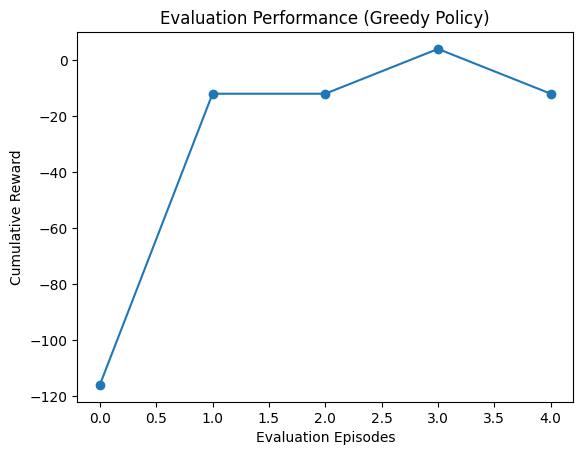

In [ ]:
# Evaluation function for greedy policy
def evaluate_model(env, q_tables, episodes=5, max_steps=50):
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        episode_reward = np.zeros(env.num_agents)

        for step in range(max_steps):
            actions = [np.argmax(q_tables[i][state]) for i in range(env.num_agents)]  # Greedy action selection
            next_state, rewards, done = env.step(actions)

            episode_reward += rewards
            state = next_state
            if done:
                break

        total_rewards.append(np.sum(episode_reward))  # Total reward across all agents in the episode

    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {episodes} evaluation episodes (greedy policy): {avg_reward}")
    return total_rewards

# Run the evaluation
evaluation_rewards = evaluate_model(env, q_tables, episodes=5)

# Plot the evaluation rewards
plt.plot(evaluation_rewards, marker='o')
plt.xlabel('Evaluation Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Evaluation Performance (Greedy Policy)')
plt.show()

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

# Define the multi-agent environment
class MultiAgentEnv(gym.Env):
    def __init__(self, num_agents=2, grid_size=10, obstacle_count=3):
        super(MultiAgentEnv, self).__init__()
        self.num_agents = num_agents
        self.grid_size = grid_size
        self.obstacle_count = obstacle_count
        self.action_space = spaces.MultiDiscrete([4] * num_agents)  # 4 actions for each agent
        self.observation_space = spaces.Box(low=0, high=grid_size-1, shape=(num_agents, 2), dtype=np.int32)

        # Initialize positions for agents, obstacles, and goals
        self.agent_positions = np.zeros((num_agents, 2), dtype=np.int32)
        self.goal_positions = np.array([(grid_size - 1, grid_size - 1) for _ in range(num_agents)])
        self.obstacle_positions = [self.random_position() for _ in range(3)]
        self.obstacle_directions = [(1, 0), (0, 1), (-1, 0)]  # Moving in random directions

    def reset(self, seed=None):
        # Set the random seed if provided for reproducibility
        if seed is not None:
            np.random.seed(seed)

        self.agent_positions = np.array([[0, 0] for _ in range(self.num_agents)], dtype=np.int32)
        self.goal_positions = [(self.grid_size - 1, self.grid_size - 1)] * self.num_agents
        self.obstacle_positions = [self.random_position() for _ in range(self.obstacle_count)]
        self.steps_taken = 0

        obs = self.get_state()
        info = {}  # Additional information can be added here if needed

        return obs, info  # Return observation and info tuple

    def step(self, actions):
        # Implement environment logic for one step based on `actions`
        self.steps_taken += 1
        rewards = 0.0  # Initialize cumulative reward as a float
        terminated = False
        truncated = self.steps_taken >= 100  # Truncate if max steps reached

        # Update agent positions based on actions
        for i, action in enumerate(actions):
            # Example movement based on action
            if action == 0:  # Move up
                self.agent_positions[i][1] = max(0, self.agent_positions[i][1] - 1)
            elif action == 1:  # Move down
                self.agent_positions[i][1] = min(self.grid_size - 1, self.agent_positions[i][1] + 1)
            elif action == 2:  # Move left
                self.agent_positions[i][0] = max(0, self.agent_positions[i][0] - 1)
            elif action == 3:  # Move right
                self.agent_positions[i][0] = min(self.grid_size - 1, self.agent_positions[i][0] + 1)

            # Check if agent reached its goal
            if tuple(self.agent_positions[i]) == self.goal_positions[i]:
                rewards += 1.0  # Accumulate reward as a float
                terminated = True  # End episode if any agent reaches its goal

        obs = self.get_state()
        info = {}  # Additional information can be added here if needed

        # Return obs, cumulative reward, terminated, truncated, and info
        return obs, rewards, terminated, truncated, info

    def get_state(self):
        # Returns the current positions of the agents
        return self.agent_positions

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), '.', dtype=str)
        for pos in self.obstacle_positions:
            grid[pos] = 'O'  # Obstacles
        for pos in self.goal_positions:
            grid[pos] = 'G'  # Goals
        for i, pos in enumerate(self.agent_positions):
            grid[tuple(pos)] = f'A{i}'  # Agents
        print("\n".join(" ".join(row) for row in grid))
        print()

    def random_position(self):
        return (np.random.randint(self.grid_size), np.random.randint(self.grid_size))



# Initialize the environment and check it
env = MultiAgentEnv(num_agents=2, grid_size=10)
check_env(env)  # Ensure it’s compatible with Gym

# Wrap in a vectorized environment for stable-baselines
vec_env = DummyVecEnv([lambda: env])

# Instantiate the PPO agent
model = PPO("MlpPolicy", vec_env, verbose=1)

# Training the model
timesteps = 10000  # You can adjust the number of timesteps for your needs
model.learn(total_timesteps=timesteps)

# Save the model
model.save("multi_agent_baseline_model")

def evaluate_model(model, env, num_episodes=5):
    for episode in range(num_episodes):
        # If using Gym, reset() returns (obs, info), so only use obs
        obs, info = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Ensure only the observation is passed, not a tuple (obs, info)
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward  # Aggregate reward for all agents

        print(f"Episode {episode + 1}: Total Reward: {episode_reward}")
evaluate_model(model, env)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 4449 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3250        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013898334 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | -0.3069495  |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0258     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 0.0161      |
-----------------------------------------
-----------------